In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import geopandas as gpd
import geobr
import seaborn as sns
import geobr
sns.set(style="white")

In [2]:
sys.path.append('..')

In [3]:
df = pd.read_csv('../Data/processed/pertussis_total.csv', 
                delimiter = ',',
                index_col=False,
                parse_dates = ['DT_SIN_PRI','DT_NOTIFIC'], encoding="utf8")

C:\Users\denise.cammarota\AppData\Local\Temp\ipykernel_30964\3505764348.py:1: DtypeWarning: Columns (9,15,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/processed/pertussis_total.csv',


In [11]:
mun_path = '../Data/municipalities.csv'
mun_file = pd.read_csv(mun_path)
mun_file['codigo'] = mun_file['municipio'].astype(str).str[:6].astype(int)
mun_file = mun_file[['municipio','name','codigo','pop_21']]

## Time series in Brazil

In [49]:
df['CASOS'] = 1
df_cases_total = df.groupby(['NU_ANO'])['CASOS'].sum()
df_cases_total = df_cases_total.reset_index(name = 'CASOS_ANO')

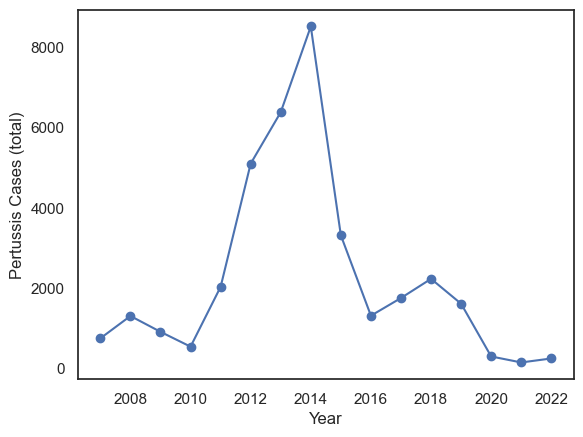

In [54]:
plt.plot(df_cases_total['NU_ANO'],df_cases_total['CASOS_ANO'],'-o')
plt.xlabel('Year')
plt.ylabel('Pertussis Cases (total)')
plt.show()

## Vaccination status of cases

### National

In [4]:
100*df['CS_VAC_N'].value_counts()/df.shape[0]

6    24.599868
9    19.263868
1    16.610941
4    10.233501
3     8.079369
      7.638128
2     6.988599
5     6.585727
Name: CS_VAC_N, dtype: float64

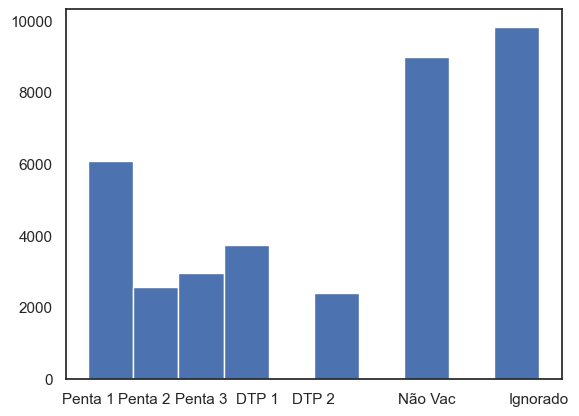

In [5]:
a = df['CS_VAC_N']
a = a.fillna('9')
a[a == ' '] = '9'
a.unique()
a = a.astype(int)
a[a == 6] = 7
x = a.unique()
x = sorted(x)
labels = ['Penta 1', 'Penta 2', 'Penta 3', 'DTP 1', 'DTP 2', 'Não Vac', 'Ignorado']
plt.hist(a)
plt.xticks(x, labels)
plt.show()

### For the state of SP

In [6]:
df_sp = df[df['SG_UF'] == 35]

In [7]:
100*df_sp['CS_VAC_N'].value_counts()/df_sp.shape[0]

9    24.084778
6    18.882466
3    13.872832
1    12.331407
5     9.248555
4     8.477842
2     7.321773
      5.780347
Name: CS_VAC_N, dtype: float64

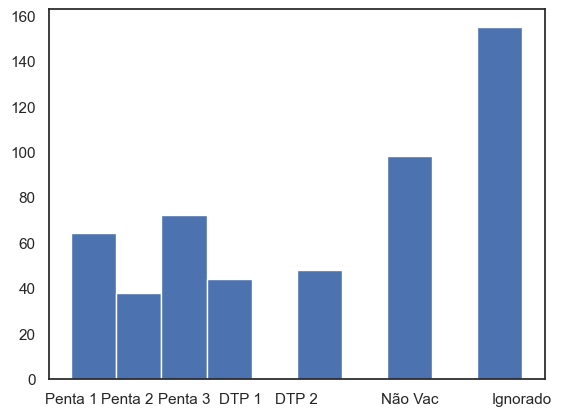

In [8]:
a = df_sp['CS_VAC_N']
a = a.fillna('9')
a[a == ' '] = '9'
a.unique()
a = a.astype(int)
a[a == 6] = 7
x = a.unique()
x = sorted(x)
labels = ['Penta 1', 'Penta 2', 'Penta 3', 'DTP 1', 'DTP 2', 'Não Vac', 'Ignorado']
plt.hist(a)
plt.xticks(x, labels)
plt.show()

## Age distribution of cases

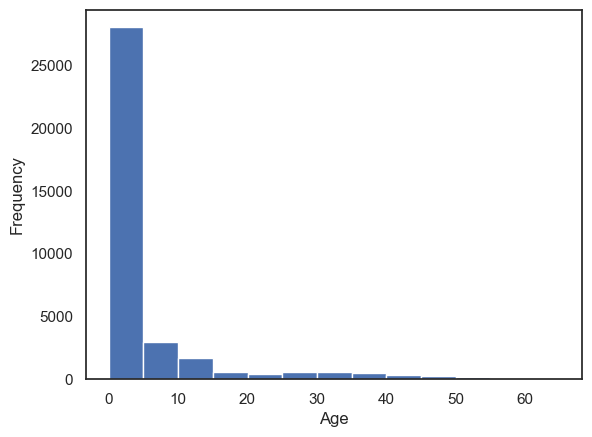

In [9]:
plt.hist(df['idade_anos'], bins = np.arange(0,70,5))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Prevalence map per municipality

In [36]:
df['CASOS'] = 1
df_cases = df.groupby(['ID_MUNICIP'])['CASOS'].sum()
df_cases = df_cases.reset_index(name = 'CASOS_T')
df_cases = df_cases.merge(mun_file, how = 'left', left_on = 'ID_MUNICIP', right_on = 'codigo')
df_cases = df_cases.drop(columns = ['codigo'])
df_cases['CASOS_100'] = (df_cases['CASOS_T']/df_cases['pop_21'])*(10**5)

In [37]:
map_br = geobr.read_municipality()

In [38]:
map_br = map_br.merge(df_cases, how = 'left', left_on = 'code_muni', right_on = 'municipio')

C:\Users\denise.cammarota\AppData\Local\anaconda3\lib\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\denise.cammarota\AppData\Local\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\denise.cammarota\AppData\Local\anaconda3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Users\denise.cammarota\AppData\Local\anaconda3\lib\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over mu

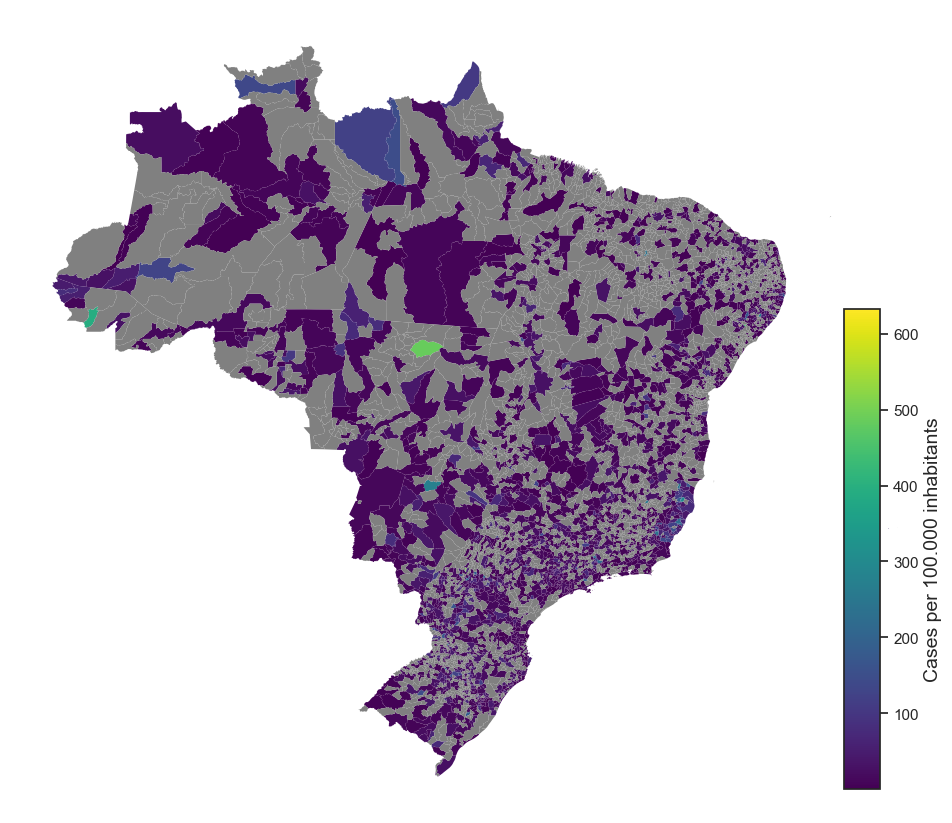

In [43]:
missing_kwds = dict(color='grey', label='No Data')

fig, axs = plt.subplots(figsize = (12,12))

map_br.plot(
        ax=axs, 
        column='CASOS_100', 
        missing_kwds=missing_kwds,
        linewidth=0.0,
        cmap = 'viridis'
    )


cax = fig.add_axes(
        [
            0.82,    # posicao x (entre 0.0 e 1.0)
            0.18,    # posicao y (entre 0.0 e 1.0)
            0.03,    # largura x
            0.40,    # altura y
        ]
    )

sm = plt.cm.ScalarMappable(
        cmap="viridis",                                       
        norm=plt.Normalize(
            vmin=map_br["CASOS_100"].min(),  
            vmax=map_br["CASOS_100"].max(),  
        ),
    )
    
fig.colorbar(
    sm,
    cax=cax)

#axs.set_title(
 #   "Date of symptom onset of first case of Measles per municipality",
 #  fontdict={"fontsize": 15},
 #   )
cax.set_ylabel('Cases per 100.000 inhabitants', rotation=90, fontsize = 14)

axs.axis("off") 
#plt.savefig('../Figs/cases_100k_map.pdf',bbox_inches='tight')
plt.show()

In [44]:
map_br['LOG'] = np.log(map_br['CASOS_100'])

C:\Users\denise.cammarota\AppData\Local\anaconda3\lib\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
C:\Users\denise.cammarota\AppData\Local\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\denise.cammarota\AppData\Local\anaconda3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\Users\denise.cammarota\AppData\Local\anaconda3\lib\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over mu

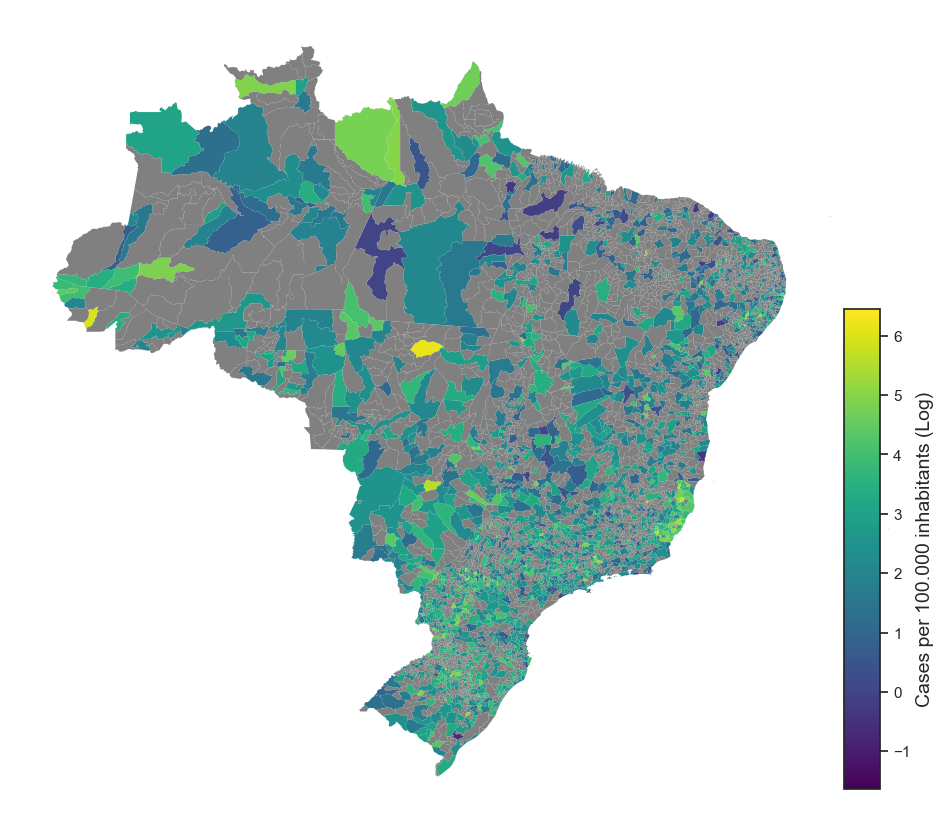

In [45]:
missing_kwds = dict(color='grey', label='No Data')

fig, axs = plt.subplots(figsize = (12,12))

map_br.plot(
        ax=axs, 
        column='LOG', 
        missing_kwds=missing_kwds,
        linewidth=0.0,
        cmap = 'viridis'
    )


cax = fig.add_axes(
        [
            0.82,    # posicao x (entre 0.0 e 1.0)
            0.18,    # posicao y (entre 0.0 e 1.0)
            0.03,    # largura x
            0.40,    # altura y
        ]
    )

sm = plt.cm.ScalarMappable(
        cmap="viridis",                                       
        norm=plt.Normalize(
            vmin=map_br["LOG"].min(),  
            vmax=map_br["LOG"].max(),  
        ),
    )
    
fig.colorbar(
    sm,
    cax=cax)

#axs.set_title(
 #   "Date of symptom onset of first case of Measles per municipality",
 #  fontdict={"fontsize": 15},
 #   )
cax.set_ylabel('Cases per 100.000 inhabitants (Log)', rotation=90, fontsize = 14)

axs.axis("off") 
#plt.savefig('../Figs/cases_100k_map.pdf',bbox_inches='tight')
plt.show()

## Municipalities with most cases

In [70]:
a = df_cases.sort_values(by=['CASOS_100'],ascending = False)[['ID_MUNICIP','name','CASOS_100']]
a[0:20]

,ID_MUNICIP,name,CASOS_100
496,270620,Palestina,632.286109
1663,412360,Santa Inês,510.204082
2134,510558,Marcelândia,484.812506
486,270370,Jaramataia,434.707007
25,120032,Jordão,394.065832
1110,320517,Vila Valério,298.613580
2065,500025,Alcinópolis,273.273820
512,270810,Santana do Mundaú,263.232114
1773,420895,Jardinópolis,263.157895
936,314995,Periquito,252.300386


In [73]:
b = df_cases.sort_values(by=['CASOS_T'],ascending = False)[['ID_MUNICIP','name','CASOS_T']]
b[0:20]

,ID_MUNICIP,name,CASOS_T
441,261160,Recife,2584
1430,355030,São Paulo,2526
1982,431490,Porto Alegre,1286
2230,530010,Brasília,1071
1529,410690,Curitiba,919
1056,320130,Cariacica,701
212,221100,Teresina,679
48,130260,Manaus,666
1227,350950,Campinas,648
1153,330455,Rio de Janeiro,625
